<a href="https://colab.research.google.com/github/emin-ozturk/JaundiceDetection/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#GPU kullanmak için kimlik doğrulama işlemi
from google.colab import drive
drive.mount('/gdrive')


In [ ]:
import os
os.chdir("/gdrive/My Drive/Makale")
!ls

# 1.ADIM: Gereken kütüphanelerin yüklenmesi

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

In [ ]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Görüntü hazırlama

In [ ]:
import cv2
from imutils import paths
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [ ]:
def getImage(dataPaths):
  images = []
  for path in dataPaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    images.append(image)
  images = np.array(images)
  print("Görüntüler verileri alındı")
  return images

In [ ]:
def loadImage():
  !unzip goz.zip
  print("Görüntüler yüklendi")
  return list(paths.list_images("goz"))

In [ ]:
def getLabel(dataPaths):
  labels = []
  lb = LabelBinarizer()
  for path in dataPaths:
    labels.append(path.split(os.path.sep)[-2])
  labels = np.array(labels)
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  print("Etiket verileri yüklendi")
  return labels, lb

In [ ]:
def getImageDataGenerator():
  train = ImageDataGenerator()
  mean = np.array([123.68, 116.779, 103.939], dtype="float32")
  train.mean = mean
  return train

In [ ]:
dataPaths = loadImage()
images = getImage(dataPaths)
labels, lb = getLabel(dataPaths)
x_train, x_test, y_train, y_test = train_test_split(images, labels,	test_size=0.2, random_state=109)

# 2.ADIM: Verilerin yüklenmesi ve önişlemlerin gerçekleştirilmesi

In [ ]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [ ]:
# Veri kümesinden 10x10 piksel büyüklüklü 25 tane örnek ekrana yazdırıp neye benzediğine bakalım.
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

# 3.ADIM: Eğtim verileri ve gruplarının oluşturulması

In [ ]:
batch_size = 32
# Bu veri kümesi, bir arabelleği buffer_size elemanları ile doldurur,
# ardından seçilen elemanları yeni elemanlarla değiştirerek rastgele örnekler.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
# Bu veri kümesinin ardışık öğelerini toplu olarak birleştirir.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# 4.ADIM: GAN için üretici (generator) ağının oluşturulması




In [ ]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

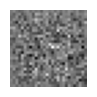

In [ ]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
show(generated_images, 1)

# **5.ADIM: GAN için ayırıcı (discriminator) ağının oluşturulması**


In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Üretilen görsel için ayırt edici %50 nin altında bir değer üretti ilk adım için
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.5011651]], shape=(1, 1), dtype=float32)


# 6.ADIM: Derin Evrişimli Üretici Çekişmeli Ağınızı Derlenmesi


In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# 7.ADIM: Eğitim işlemlerini görseleştirilmesi


In [ ]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Üretilen görüntüleri ekrana yazdırıp doyaya kaydedelim
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# 8.ADIM: DCGAN'ın eğitilmesi
Bu adımda tanımladığımız gan, dataset, batch_size, num_features ve epoch değerlerine göre eğitim işlemini gerçekleştirip sonuçları ekrana yazdırıyoruz.

In [ ]:
# Eğitim için yeniden boyutlandırmanın yapılması
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
#Batch size boyutunun ve shuffle özelliklerinin belirlenmesi
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=500)

# 9.ADIM: GAN ile sentetik görüntülerin oluşturulması


In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)